# 第7章 数据清洗和准备

在__数据分析和建模__的过程中，相当多的时间要用在__数据准备__上：**加载、清理、转换以及重塑**。这些工作会占到分析师时间的__80%或更多__。有时，存储在__文件和数据库__中的__数据的格式__不适合某个__特定的任务__。

许多研究者都选择使用__通用编程语言__(如Python、Perl、R或Java)或__UNIX文本处理工具__(如sed或awk)对__数据格式__进行__专门处理__。幸运的是，__pandas__和__内置的Python标准库__提供了一组高级的、灵活的、快速的__工具__，可以让你轻松地将__数据__规变为__想要的格式__。

如果你发现了一种本书或pandas库中没有的数据操作方式，请尽管在邮件列表或GitHub网站上提出。实际上，pandas的许多__设计和实现__都是由__真实应用__的需求所驱动的。

在本章中，会讨论**处理** __缺失__数据、__重复__数据、__字符串操作__和其它__分析数据转换__的__工具__。

下一章，会关注于用__多种方法__ **合并、重塑**数据集。

# 1.处理缺失数据

在许多__数据分析__工作中，__缺失数据__是经常发生的。pandas的__目标之一__就是__尽量轻松__地处理__缺失数据__。

例如，pandas对象的__所有描述性统计__ 默认都__不包括缺失数据__。

__缺失数据__在pandas中__呈现的方式__有些不完美，但对于大多数用户可以保证__功能正常__。

对于__数值数据__，pandas使用__浮点值NaN__(Not a Number)表示缺失数据。称其为__哨兵值__，可以__方便__的__检测__出来：

In [1]:
import pandas as pd
import numpy as np

In [2]:
string_data = pd.Series(['aardvark', 'artichoke', np.nan, 'avocado'])

string_data

0     aardvark
1    artichoke
2          NaN
3      avocado
dtype: object

In [3]:
string_data.isnull()

0    False
1    False
2     True
3    False
dtype: bool

在pandas中，采用了R语言中的惯用法，即将__缺失值__表示为__NA__，它表示__不可用not available__。在__统计应用__中，__NA数据__可能是__不存在的数据__或者虽然__存在__，但是__没有观察到__(例如，__数据采集__中发生了问题)。

当进行__数据清洗__以进行__分析__时，最好__直接__对__缺失__数据进行分析，以判断__数据采集__的问题或__缺失数据__可能导致的__偏差__。

Python**内置**的__None值__在__对象数组__中也可以作为__NA__：

In [4]:
string_data[0] = None

string_data

0         None
1    artichoke
2          NaN
3      avocado
dtype: object

In [5]:
string_data.isnull()

0     True
1    False
2     True
3    False
dtype: bool

pandas项目中还在不断__优化内部细节__以__更好__处理缺失数据，像__用户API功能__，例如__pandas.isnull__，去除了许多恼人的细节。

表7-1列出了一些关于__缺失数据处理__的__函数__。
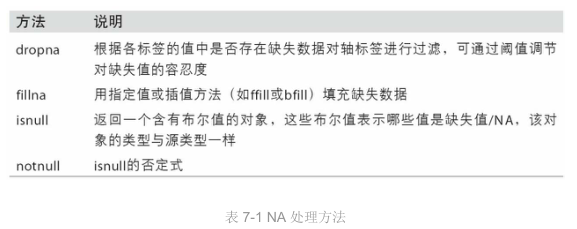

# 1.1 滤除缺失数据

__过滤__掉__缺失数据__的办法有__很多种__。

你可以通过__pandas.isnull__或__布尔索引__的__手工方法__，但__dropna__可能会__更实用__一些。

### 1.1.1 Series
对于一个Series，__dropna__返回一个__仅含非空数据__和__索引值__的__Series__：

In [6]:
from numpy import nan as NA

In [7]:
data = pd.Series([1, NA, 3.5, NA, 7])

data

0    1.0
1    NaN
2    3.5
3    NaN
4    7.0
dtype: float64

In [8]:
data.dropna()

0    1.0
2    3.5
4    7.0
dtype: float64

这__等价__于:

In [9]:
data[data.notnull()]

0    1.0
2    3.5
4    7.0
dtype: float64

### 1.1.2 DataFrame

1.1.2.1 对于DataFrame对象，事情就__有点复杂__了。你可能希望丢弃**全NA或含有NA**的__行或列__。

- dropna**默认**丢弃**任何含有缺失值**的__行__：

In [10]:
data = pd.DataFrame([[1., 6.5, 3.], [1., NA, NA], 
                     [NA, NA, NA], [NA, 6.5, 3.]])

data

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


In [11]:
cleaned = data.dropna()

cleaned

,0,1,2
0,1.0,6.5,3.0


- 传入__how="all"__将只丢弃__全为NA__的那些__行__:

In [12]:
data.dropna(how="all")

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
3,NaN,6.5,3.0


- 用这种方式丢弃**列**，只需传入__axis=1__即可：

In [13]:
data[4] = NA

data

,0,1,2,4
0,1.0,6.5,3.0,NaN
1,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,6.5,3.0,NaN


In [14]:
data.dropna(axis=1, how="all")

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


1.1.2.2 另一个滤除__DataFrame行__的问题涉及__时间序列数据__。

- 假设你只想留下__一部分观测数据__，可以用__thresh参数__实现此目的：

In [15]:
df = pd.DataFrame(np.random.randn(7, 3))

df.iloc[:4, 1] = NA
df.iloc[:2, 2] = NA

df

,0,1,2
0,-1.060346,NaN,NaN
1,-0.914676,NaN,NaN
2,-1.336374,NaN,0.321222
3,-2.120584,NaN,-0.231701
4,1.260056,-0.788101,0.044585
5,1.380401,2.502340,0.205991
6,-0.599829,-0.227656,-0.296988


In [16]:
df.dropna()

,0,1,2
4,1.260056,-0.788101,0.044585
5,1.380401,2.502340,0.205991
6,-0.599829,-0.227656,-0.296988


In [17]:
# thresh=n:保留至少有n个*非NaN数据*的行
df.dropna(thresh=2)

,0,1,2
2,-1.336374,NaN,0.321222
3,-2.120584,NaN,-0.231701
4,1.260056,-0.788101,0.044585
5,1.380401,2.502340,0.205991
6,-0.599829,-0.227656,-0.296988


## 1.2 填充缺失数据

你可能__不想滤除__缺失数据(有可能会丢弃跟它有关的其他数据)，而是希望通过其他方式__填补__那些“空洞”。

对于__大多数情况__而言，__fillna方法__是最主要的函数。通过一个__常数__调用__fillna__就会将__缺失值__替换为那个__常数值__：

In [18]:
df.fillna(0)

,0,1,2
0,-1.060346,0.000000,0.000000
1,-0.914676,0.000000,0.000000
2,-1.336374,0.000000,0.321222
3,-2.120584,0.000000,-0.231701
4,1.260056,-0.788101,0.044585
5,1.380401,2.502340,0.205991
6,-0.599829,-0.227656,-0.296988


- 若是通过一个__字典__调用__fillna__，就可以实现对__不同的列__填充__不同的值__：

In [19]:
df.fillna({1: 0.5, 2: 0})

,0,1,2
0,-1.060346,0.500000,0.000000
1,-0.914676,0.500000,0.000000
2,-1.336374,0.500000,0.321222
3,-2.120584,0.500000,-0.231701
4,1.260056,-0.788101,0.044585
5,1.380401,2.502340,0.205991
6,-0.599829,-0.227656,-0.296988


- fillna**默认**会返回__新对象__，但也可以对**现有对象**进行**就地修改**：

In [20]:
_ = df.fillna(0, inplace=True)

In [21]:
df

,0,1,2
0,-1.060346,0.000000,0.000000
1,-0.914676,0.000000,0.000000
2,-1.336374,0.000000,0.321222
3,-2.120584,0.000000,-0.231701
4,1.260056,-0.788101,0.044585
5,1.380401,2.502340,0.205991
6,-0.599829,-0.227656,-0.296988


- 对__reindexing__有效的那些__插值方法__也可用于__fillna__：

In [33]:
df = pd.DataFrame(np.random.randn(6, 3))

df.iloc[2:, 1] = NA

df.iloc[4:, 2] = NA

df

,0,1,2
0,0.331920,0.414762,0.320223
1,1.134486,0.075236,-1.205315
2,1.190374,NaN,0.590376
3,-0.362198,NaN,-0.438894
4,0.732266,NaN,NaN
5,-0.046404,NaN,NaN


In [34]:
df[1][4] = 2

df

,0,1,2
0,0.331920,0.414762,0.320223
1,1.134486,0.075236,-1.205315
2,1.190374,NaN,0.590376
3,-0.362198,NaN,-0.438894
4,0.732266,2.000000,NaN
5,-0.046404,NaN,NaN


In [35]:
df.fillna(method='ffill')

,0,1,2
0,0.331920,0.414762,0.320223
1,1.134486,0.075236,-1.205315
2,1.190374,0.075236,0.590376
3,-0.362198,0.075236,-0.438894
4,0.732266,2.000000,-0.438894
5,-0.046404,2.000000,-0.438894


In [36]:
df.fillna(method="ffill", limit=1)

,0,1,2
0,0.331920,0.414762,0.320223
1,1.134486,0.075236,-1.205315
2,1.190374,0.075236,0.590376
3,-0.362198,NaN,-0.438894
4,0.732266,2.000000,-0.438894
5,-0.046404,2.000000,NaN


只要有些创新，你就可以利用**fillna**实现许多__别的功能__。比如说，你可以传入__Series__的__平均值或中位数__：

In [25]:
data = pd.Series([1., NA, 3.5, NA, 7])

data

0    1.0
1    NaN
2    3.5
3    NaN
4    7.0
dtype: float64

In [26]:
data.fillna(data.mean())

0    1.000000
1    3.833333
2    3.500000
3    3.833333
4    7.000000
dtype: float64

表7-2列出了__fillna的参考__:
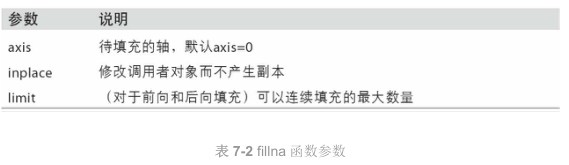

# 2.数据转换

本章到目前为止介绍的都是__数据的重排__。另一类__重要操作__则是__过滤__、__清理__以及__其他__的__转换工作__。

## 2.1 移除重复数据

__DataFrame__中出现__重复行__有__多种原因__。下面就是一个例子：

In [37]:
data = pd.DataFrame({'k1': ['one', 'two'] * 3 + ['two'],
                     'k2':[1, 1, 2, 3, 3, 4, 4]})

data

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4
6,two,4


- __DataFrame__的__duplicated方法__返回一个__布尔型Series__，表示__各行__是否是__重复行__(__前面出现__过的行)：

In [38]:
data.duplicated()

0    False
1    False
2    False
3    False
4    False
5    False
6     True
dtype: bool

- 还有一个与此相关的__drop_duplicates方法__，它会返回一个__DataFrame__，__重复的数组__会标为__False__：

In [39]:
data.drop_duplicates()

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4


- 这两个方法__默认__会判断__全部列__，你也可以指定__部分列__进行__重复项判断__。

假设我们__还有一列值__，且只希望根据__k1列__过滤__重复项__：

In [40]:
data['v1'] = range(7)

data

,k1,k2,v1
0,one,1,0
1,two,1,1
2,one,2,2
3,two,3,3
4,one,3,4
5,two,4,5
6,two,4,6


In [41]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
1,two,1,1


- duplicated和drop_duplicates**默认**保留的是**第一个出现**的__值组合__。传入__keep='last'__则保留__最后一个__：

In [42]:
data.drop_duplicates(['k1', 'k2'], keep='last')

,k1,k2,v1
0,one,1,0
1,two,1,1
2,one,2,2
3,two,3,3
4,one,3,4
6,two,4,6


## 2.2 利用函数或映射进行数据转换

对于许多数据集，你可能希望根据__数组、Series__或**DataFrame列中的值**来实现__转换工作__。

我们来看看下面这组有关__肉类__的数据：

In [43]:
data = pd.DataFrame({'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami', 'corned beef', 'Bacon', 'pastrami', 'honey ham', 'nova lox'], 
                     'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})

data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


假设你想要__添加一列__表示该肉类食物__来源__的__动物类型__。我们先编写一个__不同肉类__到__动物__的__映射__：

In [44]:
meat_to_animal = {
    'bacon': 'pig', 
    'pulled pork': 'pig',
    'pastrami': 'cow',
    'corned beef': 'cow',
    'honey ham': 'pig',
    'nova lox': 'salmon'
}

- __Series__的__map方法__可以接受一个__函数__或__含有映射关系__的__字典型对象__

- 但是这里有一个__小问题__，即有些肉类的__首字母__大写了，而另一些则没有。因此，我们还需要使用__Series__的__str.lower方法__，将各个值转换为__小写__：

In [49]:
lowercased = data['food'].str.lower()

lowercased

0          bacon
1    pulled pork
2          bacon
3       pastrami
4    corned beef
5          bacon
6       pastrami
7      honey ham
8       nova lox
Name: food, dtype: object

In [50]:
data['animal'] = lowercased.map(meat_to_animal)

data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


- 我们也可以传入一个能够完成__全部这些工作__的__函数__：

In [51]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

- 使用__map__是一种实现__元素级转换__以及__其他数据清理工作__的__便捷__方式。

## 2.3 替换值

利用__fillna方法__填充__缺失数据__可以看做__值替换__的一种__特殊情况__。

前面已经看到，__map__可用于__修改对象的数据子集__，而__replace__则提供了一种实现__该功能__的
更__简单__、更__灵活__的方式。

我们来看看下面这个__Series__：

In [52]:
data = pd.Series([1., -999., 2., -999., -1000., 3.])

data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

-999这个值可能是一个表示__缺失数据__的__标记值__。要将其__替换__为__pandas能够理
解__的__NA值__，

- 我们可以利用__replace__来产生一个__新的Series__(除非传入__inplace=True__)：

In [53]:
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

- 如果你希望__一次性__替换__多个值__，可以传入一个由__待替换值__组成的__列表__以及__一个替换值__：

In [54]:
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

- 要让__每个值__有__不同__的__替换值__，可以传递一个__替换列表__：

In [55]:
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

- 传入的参数也可以是__字典__：

In [56]:
data.replace({-999: np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

笔记：__data.replace方法__与__data.str.replace__不同，__后者__做的是__字符串__的__元素级替换__。我们会在后面学习__Series__的__字符串方法__。

## 2.4 重命名轴索引

跟__Series__中的值一样，__轴标签__也可以通过__函数或映射__进行__转换__，从而得到一个__新的不同标签的对象__。

__轴__还可以被**就地修改**，而**无需新建**一个**数据结构**。接下来看看下面这个简单的例子：

In [59]:
data = pd.DataFrame(np.arange(12).reshape(3, 4),
                   index=['Ohio', 'Coloeado', 'New York'],
                   columns=['one', 'two', 'three', 'four'])

data

,one,two,three,four
Ohio,0,1,2,3
Coloeado,4,5,6,7
New York,8,9,10,11


- 跟__Series__一样，__轴索引__也有一个__map方法__：

In [60]:
transform = lambda x: x[:4].upper()

In [61]:
data.index.map(transform)

Index(['OHIO', 'COLO', 'NEW '], dtype='object')

- 你可以将其__赋值__给__index__，这样就可以对__DataFrame__进行__就地修改__：

In [62]:
data.index = data.index.map(transform)

data

,one,two,three,four
OHIO,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


- 如果想要创建__数据集__的__转换版__(而不是修改__原始数据__)，比较__实用__的方法是__rename__：

In [63]:
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colo,4,5,6,7
New,8,9,10,11


- 特别说明一下，__rename__可以结合__字典型对象__实现对__部分轴标签__的__更新__：

In [64]:
data.rename(index={'OHIO': 'INDIANA'},
           columns={'three': 'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


- __rename__可以实现__复制DataFrame__并对其__索引和列标签__进行__赋值__。如果希望__就地修改__某个__数据集__，传入__inplace=True__即可：

In [65]:
data.rename(index={'OHIO': 'INDIANA'}, inplace=True)

data

,one,two,three,four
INDIANA,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


## 2.5 离散化和面元划分

为了__便于分析__，__连续数据__常常被__离散化__或__拆分为“面元”(bin)__。

假设有一组__人员数据__，而你希望将它们划分为__不同__的__年龄组__：

In [66]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

接下来将这些数据__划分为__“18 到 25”、“25 到 35”、“35 到 60”以及“60以上”几个__面元__。
- 要实现该功能，你需要使用__pandas__的__cut函数__：

In [67]:
bins = [18, 25, 35, 60, 100]

In [68]:
cats = pd.cut(ages, bins)

cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

pandas**返回**的是一个**特殊**的**Categorical对象**。

- __结果__展示了__pandas.cut__划分的__面元__。你可以将其看做__一组__表示__面元名称__的__字符串__。

- 它的__底层__含有一个表示__不同分类名称__的__类型数组__，以及一个__codes属性__中的__年龄数据__的__标签__：

In [69]:
cats.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [70]:
cats.categories

IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]]
              closed='right',
              dtype='interval[int64]')

In [71]:
pd.value_counts(cats)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

pd.value_counts(cats)是__pandas.cut结果__的__面元计数__。

- 跟“区间”的数学符号一样，圆括号表示__开端__，而方括号则表示__闭端(包括)__。哪边是__闭端__可以通过__right=False__进行__修改__：

In [72]:
pd.cut(ages, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, interval[int64]): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

- 你可以通过传递一个__列表或数组__到__labels__，设置自己的__面元名称__：

In [73]:
group_names = ["Youth", "YoungAdult", "MiddleAged", "Senior"]

In [74]:
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

- 如果向__cut__传入的是__面元的数量__而不是__确切__的__面元边界__，则它会根据__数据__的__最小值和最大值__计算__等长面元__。

下面这个例子中，我们将一些__均匀分布__的__数据__分成__四组__：

注释：
- np.random.rand():返回__一个或一组__服从__“0~1”均匀分布__的__随机样本值__。随机样本__取值范围__是[0,1)，不包括1。
- np.random.randn():__标准正态分布__

In [78]:
data = np.random.rand(20)

data

array([0.85451565, 0.98530011, 0.69170826, 0.40428824, 0.00409416,
       0.54650995, 0.85372478, 0.94279819, 0.94020773, 0.5211699 ,
       0.06784936, 0.17895439, 0.15951833, 0.30372289, 0.3099646 ,
       0.09085143, 0.01316761, 0.56913313, 0.3873881 , 0.65398137])

In [79]:
pd.cut(data, 4, precision=2)

[(0.74, 0.99], (0.74, 0.99], (0.49, 0.74], (0.25, 0.49], (0.0031, 0.25], ..., (0.0031, 0.25], (0.0031, 0.25], (0.49, 0.74], (0.25, 0.49], (0.49, 0.74]]
Length: 20
Categories (4, interval[float64]): [(0.0031, 0.25] < (0.25, 0.49] < (0.49, 0.74] < (0.74, 0.99]]

- 选项precision=2，限定__小数__只有__两位__。

- __qcut__是一个非常__类似于cut__的__函数__，它可以根据__样本分位数__对__数据__进行__面元划分__。

根据__数据的分布情况__，__cut__可能无法使__各个面元__中含有__相同数量__的__数据点__。

而__qcut__由于使用的是__样本分位数__，因此可以得到__大小基本相等__的__面元__：

In [81]:
data = np.random.randn(1000) # Normally distributed

#data

In [87]:
cats = pd.qcut(data, 4) # Cut into quartiles

cats

[(0.0614, 0.742], (0.0614, 0.742], (-0.609, 0.0614], (0.742, 3.283], (0.742, 3.283], ..., (0.742, 3.283], (0.742, 3.283], (0.0614, 0.742], (-2.4539999999999997, -0.609], (-0.609, 0.0614]]
Length: 1000
Categories (4, interval[float64]): [(-2.4539999999999997, -0.609] < (-0.609, 0.0614] < (0.0614, 0.742] < (0.742, 3.283]]

In [88]:
pd.value_counts(cats)

(0.742, 3.283]                   250
(0.0614, 0.742]                  250
(-0.609, 0.0614]                 250
(-2.4539999999999997, -0.609]    250
dtype: int64

- 与__cut类似__，你也可以传递__自定义的分位数__(__0到1__之间的数值，__包含端点__)：

In [89]:
pd.qcut(data, [0 ,0.1, 0.5, 0.9, 1.])

[(0.0614, 1.27], (0.0614, 1.27], (-1.222, 0.0614], (0.0614, 1.27], (0.0614, 1.27], ..., (1.27, 3.283], (1.27, 3.283], (0.0614, 1.27], (-1.222, 0.0614], (-1.222, 0.0614]]
Length: 1000
Categories (4, interval[float64]): [(-2.4539999999999997, -1.222] < (-1.222, 0.0614] < (0.0614, 1.27] < (1.27, 3.283]]

In [90]:
pd.value_counts(pd.qcut(data, [0 ,0.1, 0.5, 0.9, 1.]))

(0.0614, 1.27]                   400
(-1.222, 0.0614]                 400
(1.27, 3.283]                    100
(-2.4539999999999997, -1.222]    100
dtype: int64

本章稍后在讲解__聚合和分组运算__时会再次用到__cut和qcut__，因为这两个__离散化函数__对__分位和分组分析__非常__重要__。

## 2.6 检测和过滤异常值

__过滤或变换__ __异常值__(outlier)在很大程度上就是运用__数组运算__。

来看一个含有__正态分布数据__的__DataFrame__：

In [251]:
data = pd.DataFrame(np.random.randn(1000, 4))

In [252]:
data.head()

,0,1,2,3
0,1.063624,0.507562,0.247066,1.276339
1,1.710706,-0.346954,-1.755512,-0.369102
2,-0.560907,1.232112,0.145914,-2.071188
3,1.107709,-0.498095,0.838758,-1.261098
4,-0.230265,1.548343,-0.260523,-0.239079


In [209]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.052054,-0.035010,-0.007155,0.014704
std,0.969911,1.017166,1.021567,1.028501
min,-3.488399,-2.878581,-2.938085,-3.255825
25%,-0.564874,-0.683574,-0.705184,-0.683451
50%,0.078581,-0.004281,-0.023644,-0.001991
75%,0.675783,0.628566,0.666272,0.721168
max,3.521136,2.943909,3.398428,3.897527


- 假设你想要找出__某列__中__绝对值__大小__超过3__的__值__：

In [210]:
col = data[2]

In [211]:
col[np.abs(col) > 3]

179    3.003284
764    3.398428
Name: 2, dtype: float64

- 要选出__全部__ __含有__“超过3或－3的值”的**行**，你可以在__布尔型DataFrame__中使用__any方法__：

注释：
any()函数:用于判断给定的__可迭代参数__iterable**是否全部为False**。若全为False则返回False；若有一个为True，则返回True。

In [212]:
data[(np.abs(data) > 3).any(1)]

,0,1,2,3
50,0.172595,-0.923066,-1.554274,3.897527
69,3.160760,-0.718885,-1.716556,0.674845
78,-1.567338,0.706299,2.133070,3.048747
179,-0.334487,-1.361069,3.003284,2.151570
278,-3.398085,-0.349365,1.440938,0.074944
327,3.484365,-0.593819,-0.026805,0.702526
365,3.521136,1.337858,1.431504,0.094059
392,0.143912,-1.916714,0.799651,-3.255825
764,0.148179,-2.259163,3.398428,-0.146263
803,-3.019368,0.089540,-0.244526,-0.951210


In [213]:
(np.abs(data) > 3).any()

# axis=0:匹配行索引，在每列做操作

0     True
1    False
2     True
3     True
dtype: bool

In [214]:
# (np.abs(data) > 3).any(1)

# axis=1:匹配列索引，在每行做操作

In [215]:
# np.abs(data) > 3

In [216]:
# np.sign(data) * 3

根据__这些条件__，就可以对__值__进行**设置**。

下面的代码可以将**值**限制在__[－3, 3]__：

In [253]:
data[np.abs(data) > 3]

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [218]:
np.sign(data) * 3

,0,1,2,3
0,3.0,3.0,3.0,3.0
1,-3.0,-3.0,3.0,-3.0
2,-3.0,3.0,3.0,3.0
3,3.0,3.0,3.0,3.0
4,-3.0,3.0,3.0,3.0
5,-3.0,-3.0,-3.0,3.0
6,3.0,3.0,3.0,-3.0
7,-3.0,3.0,3.0,3.0
8,-3.0,3.0,-3.0,3.0
9,3.0,-3.0,3.0,-3.0


In [219]:
data[np.abs(data) > 3] = np.sign(data) * 3

In [220]:
data.head()

,0,1,2,3
0,1.440670,0.633386,0.925563,0.075544
1,-0.689847,-0.160437,0.730806,-0.660930
2,-0.338339,0.750402,1.374380,2.436133
3,1.331873,1.834021,0.584774,0.151314
4,-0.415778,1.387511,1.383034,1.220091


In [105]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.012268,-0.008820,0.067723,-0.029325
std,1.007014,1.001781,0.988670,0.989605
min,-2.805799,-3.000000,-3.000000,-3.000000
25%,-0.735966,-0.693738,-0.568897,-0.640406
50%,0.034081,0.016819,0.076379,-0.007670
75%,0.675616,0.681076,0.718728,0.618208
max,2.913815,3.000000,2.996810,3.000000


注释：
根据数据的__值__是**正还是负**，**np.sign(data)**可以生成**1和-1**：
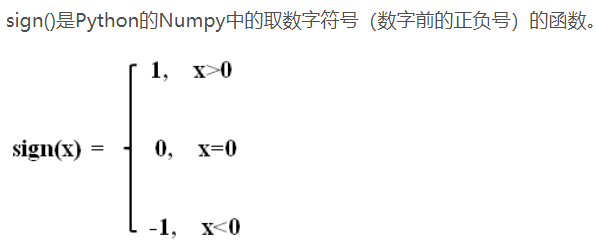

In [106]:
np.sign(data).head()

,0,1,2,3
0,1.0,1.0,1.0,-1.0
1,1.0,-1.0,1.0,1.0
2,-1.0,1.0,1.0,-1.0
3,-1.0,1.0,1.0,-1.0
4,-1.0,1.0,-1.0,-1.0


## 2.7 排列和随机采样

### 2.7.1 排列
利用__numpy.random.permutation函数__可以轻松实现对__Series或DataFrame__的__列__的**排列工作**(permuting，随机重排序)。

- 通过__需要排列__的**轴**的__长度__调用__permutation__，可产生一个__表示新顺序__的__整数数组__：

In [112]:
df = pd.DataFrame(np.arange(5 * 4).reshape((5,4))) #reshape()和reshape(())一样

In [113]:
sampler = np.random.permutation(5)

sampler

array([0, 3, 4, 2, 1])

- 然后就可以在__基于iloc的索引操作__或__take函数__中使用__该数组__了：

In [114]:
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [115]:
df.take(sampler)

,0,1,2,3
0,0,1,2,3
3,12,13,14,15
4,16,17,18,19
2,8,9,10,11
1,4,5,6,7


In [117]:
df.iloc[sampler,:]

,0,1,2,3
0,0,1,2,3
3,12,13,14,15
4,16,17,18,19
2,8,9,10,11
1,4,5,6,7


### 2.7.2 随机采样
- 如果__不想用替换的方式__选取__随机子集__，可以在__Series和DataFrame__上使用__sample方法__：

In [123]:
df.sample(n=3)

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19


- 要通过__替换的方式__产生__样本__(允许__重复选择__)，可以传递__replace=True__到**sample**：

In [124]:
choices = pd.Series([5, 7, -1, 6, 4])

In [125]:
draws = choices.sample(n=10, replace=True)

draws

1    7
4    4
2   -1
0    5
1    7
3    6
2   -1
3    6
2   -1
1    7
dtype: int64

In [129]:
choices

0    5
1    7
2   -1
3    6
4    4
dtype: int64

## 2.8 计算指标/哑变量

另一种常用于__统计建模或机器学习__的__转换方式__是：将__分类变量__(categorical variable)转换为__“哑变量”__或__“指标矩阵”__。

### 2.8.1 单成员指标变量

如果__DataFrame__的__某一列__中含有__k个不同的值__，则可以__派生__出一个__k列矩阵或DataFrame__(其__值全为1和0__)。

- __pandas__有一个__get_dummies函数__可以实现__该功能__(其实自己动手做一个也不难)。使用之前的一个DataFrame例子：

In [130]:
df = pd.DataFrame({'key':['b', 'b', 'a', 'c', 'a', 'b'],
                  'data1':range(6)})

df

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [131]:
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


有时候，你可能想给__指标DataFrame__的__列__加上一个__前缀__，以便能够跟__其他数据__进行__合并__。
- __get_dummies__的__prefix参数__可以实现__该功能__：

In [133]:
dummies = pd.get_dummies(df['key'], prefix='key')

dummies

,key_a,key_b,key_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [134]:
df_with_dummy = df[['data1']].join(dummies)

df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


注释：
join等操作

### 2.8.2 多成员指标变量

如果__DataFrame__中的__某行__ __同属于多个分类__，则事情就会__有点复杂__。看一下MovieLens 1M数据集，14章会__更深入__地研究它：

In [135]:
mnames = ['movie_id', 'title', 'genres']

In [138]:
movies = pd.read_table('pydata-book-2nd-edition/datasets/movielens/movies.dat',
                      sep="::", header=None, names=mnames, engine="python")

movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


- 要为__每个genre__添加__指标变量__就需要做一些__数据规整操作__。首先，我们从__数据集__中抽取出__不同的genre值__：

In [141]:
all_genres = []

for x in movies.genres:
    all_genres.extend(x.split('|'))
    
# all_genres

In [143]:
genres = pd.unique(all_genres)

现在有：

In [144]:
genres

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

- 构建__指标DataFrame__的__方法之一__是从一个__全零DataFrame__开始：

In [147]:
zero_matrix = np.zeros((len(movies), len(genres)))

In [148]:
dummies = pd.DataFrame(zero_matrix, columns=genres)

dummies.head()

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- 现在，__迭代__每一部电影，并将__dummies各行__的__(相应)条目设为1__。

要这么做，我们使用__dummies.columns__来计算__每个类型__的__列索引__：

In [149]:
gen = movies.genres[0]

gen.split('|')

['Animation', "Children's", 'Comedy']

In [150]:
dummies.columns.get_indexer(gen.split('|'))

array([0, 1, 2], dtype=int64)

然后，根据__索引__，使用__.iloc设定值__：

In [151]:
for i, gen in enumerate(movies.genres):
    indices = dummies.columns.get_indexer(gen.split('|'))
    dummies.iloc[i, indices] = 1

enumerate()函数：

- 语法: enumerate(sequence, [start=0])

- 参数:sequence -- 一个序列、迭代器或其他支持迭代对象;
    start -- 下标起始位置。
    
- 功能：用于将一个__可遍历__的__数据对象__(如列表、元组或字符串)__组合__为一个__索引序列__，同时列出__数据和数据下标__，一般用在__for循环__当中。

- 然后，和以前一样，再__将其与movies合并__起来：

In [152]:
movies_windic = movies.join(dummies.add_prefix('Genre_'))

In [153]:
movies_windic.iloc[0]

movie_id                                       1
title                           Toy Story (1995)
genres               Animation|Children's|Comedy
Genre_Animation                                1
Genre_Children's                               1
Genre_Comedy                                   1
Genre_Adventure                                0
Genre_Fantasy                                  0
Genre_Romance                                  0
Genre_Drama                                    0
Genre_Action                                   0
Genre_Crime                                    0
Genre_Thriller                                 0
Genre_Horror                                   0
Genre_Sci-Fi                                   0
Genre_Documentary                              0
Genre_War                                      0
Genre_Musical                                  0
Genre_Mystery                                  0
Genre_Film-Noir                                0
Genre_Western       

笔记：对于__很大的数据__，用这种方式构建__多成员指标变量__就会变得__非常慢__。

最好使用__更低级__的__函数__，将其写入__NumPy数组__，然后__结果 包装在DataFrame__中。

### tricks
一个对__统计应用__有用的__秘诀__是：结合__get_dummies__和__诸如cut之类的离散化函数__：

In [165]:
np.random.seed(12345)

# seed()方法改变随机数生成器的种子，可以在调用其他随机模块函数之前调用此函数。
# 调用其他随机模块函数之前设置同样的随机种子，每次生成的随机数相同

values = np.random.rand(10)

values

array([0.92961609, 0.31637555, 0.18391881, 0.20456028, 0.56772503,
       0.5955447 , 0.96451452, 0.6531771 , 0.74890664, 0.65356987])

In [166]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [167]:
pd.get_dummies(pd.cut(values, bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,0,0,0,0,1
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0


我们用__numpy.random.seed__，使这个例子具有__确定性__。本书后面会介绍__pandas.get_dummies__。

# 3.字符串操作

Python能够成为流行的__数据处理语言__，__部分原因__是其__简单易用__的__字符串和文本处理功能__。

- __大部分文本运算__都直接做成了__字符串对象__的__内置方法__。
- 对于__更为复杂__的__模式匹配和文本操作__，则可能需要用到__正则表达式__。__pandas__对此进行了__加强__，它使你能够对__整组数据__应用__字符串表达式和正则表达式__，而且__能处理__烦人的__缺失数据__。

## 3.1 字符串对象(的内置)方法

对于__许多字符串处理和脚本应用__，__内置__的__字符串方法__已经能够__满足要求__了。

- 例如，以__逗号__分隔的__字符串__可以用__split__拆分成__数段__：

In [221]:
val = 'a,b,  guido'

In [222]:
val.split(',')

['a', 'b', '  guido']

- __split__常常与__strip 一起使用__，以去除__空白符__(包括__换行符__)：

In [223]:
pieces = [x.strip() for x in val.split(',')]

pieces

['a', 'b', 'guido']

- 利用__加法__，可以将这些__子字符串__以__双冒号分隔符__的形式__连接__起来：

In [224]:
first, second, third = pieces

In [225]:
first + '::' + second + '::' + third

'a::b::guido'

- 但这种方式并__不是很实用__。一种__更快更符合Python风格__的方式是，向__字符串"::"__的__join方法__传入一个__列表或元组__：

In [226]:
'::'.join(pieces)

'a::b::guido'

- __其它方法__关注的是__子串定位__。__检测子串__的__最佳方式__是利用Python的__in关键字__，还可以使用__index__和__find__：

In [227]:
'guido' in val

True

In [228]:
val.index(',')

1

In [229]:
val.find(':')

-1

注意__find和index__的__区别__：如果__找不到__字符串，__index__将会引发一个__异常__(而不是返回-1)：

In [230]:
val.index(':')

ValueError: substring not found

- 与此相关，__count__可以返回__指定子串__的__出现次数__：

In [231]:
val.count(',')

2

- __replace__用于将__指定模式__替换为__另一个模式__。通过传入__空字符串__，它也常常用于__删除模式__：

In [232]:
val.replace(',', '::')

'a::b::  guido'

In [234]:
val.replace(',', '')

'ab  guido'

表7-3列出了__Python内置__的__字符串方法__。

这些运算__大部分__都能使用__正则表达式__实现(马上就会看到)。

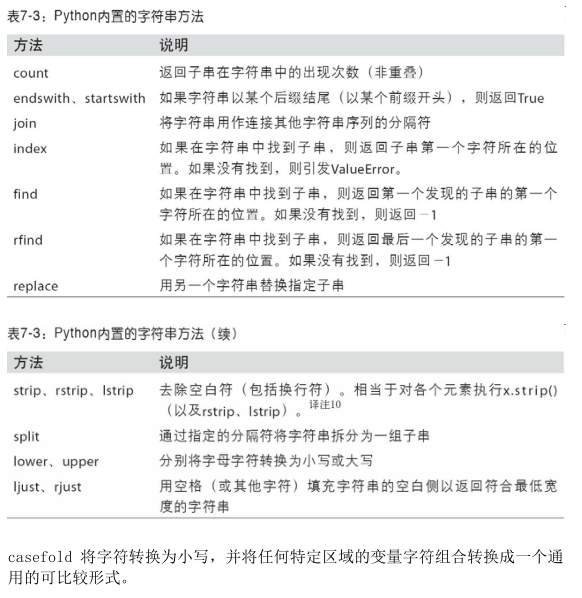

## 3.2 正则表达式

__正则表达式__提供了一种__灵活__的在__文本__中__搜索或匹配__(通常比前者__复杂__)__字符串模式__的__方式__。

正则表达式，常称作__regex__，是根据__正则表达式语言__编写的__字符串__。__Python内置__的__re模块__负责对__字符串 应用 正则表达式__。将通过一些例子说明其使用方法。

笔记:正则表达式的__编写技巧__可以__自成一章__，超出了__本书的范围__。从网上和其它书可以找到许多非常不错的__教程__和__参考资料__。

__re模块__的__函数__可以分为__三个大类__：__模式匹配、替换以及拆分__。当然，它们之间是__相辅相成__的。__一个regex 描述__了需要在__文本__中__定位__的__一个模式__，它可以用于__许多目的__。

- split方法

我们先来看一个简单的例子：假设我想要__拆分 一个字符串__，__分隔符__为__数量不定__的__一组空白符__(制表符、空格、换行符等)。

描述__一个或多个空白符__的__regex__是__\s+__：

In [254]:
import re

In [255]:
text = "foo    bar\t baz  \tqux"
text

'foo    bar\t baz  \tqux'

In [256]:
re.split('\s+', text)

['foo', 'bar', 'baz', 'qux']

调用__re.split('\s+',text)__ 时，__正则表达式__会先__被编译__，然后再在__text__上调用__其split方法__。

你可以用__re.compile 自己编译regex__以得到一个__可重用__的__regex对象__：

In [257]:
regex = re.compile('\s+')

In [258]:
regex.split(text)

['foo', 'bar', 'baz', 'qux']

- 如果只希望__得到 匹配regex的 所有模式__，则可以使用__findall方法__：

In [259]:
regex.findall(text)

['    ', '\t ', '  \t']

笔记：如果想__避免 正则表达式中 不需要的 转义(\)__ ，则可以使用__原始字符串 字面量__如 r'C:\x'(也可以编写__其等价式__'C:\\\x')。

如果打算对__许多字符串__应用__同一条 正则表达式__，强烈建议通过__re.compile 创建 regex对象__。这样将可以__节省__大量的__CPU时间__。

match和search跟findall**功能类似**:
- findall:返回字符串中__所有的 匹配项__;
- search则只返回__第一个 匹配项__;
- match更加严格，它__只匹配 字符串的 首部__。re.match()方法匹配的是以xxx开头的字符串，若不是开头的，尽管属于str内，则无法匹配。

来看一个小例子，假设我们有__一段文本__以及__一条__能够识别__大部分__电子邮件地址的__正则表达式__：

In [260]:
text = """Dave dave@google.com 
Steve steve@gmail.com 
Rob rob@gmail.com 
Ryan ryan@yahoo.com 
"""

In [278]:
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

In [262]:
# re.IGNORECASE makes the regex case-insensitive  以不区分大小写的方式对文本做查找和替换
regex = re.compile(pattern, flags=re.IGNORECASE)

- 对__text__使用__findall__将得到__一组__电子邮件地址：

In [263]:
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

- __search__返回的是__文本__中__第一个 电子邮件地址__(以__特殊的 匹配项对象__形式__返回__)。

对于上面那个__regex__，__匹配项对象__只能告诉我们__模式__在__原字符串__中的__起始和结束位置__：

In [264]:
m = regex.search(text)

m

<re.Match object; span=(5, 20), match='dave@google.com'>

In [265]:
text[m.start():m.end()]

'dave@google.com'

- __regex.match__则将返回__None__，因为它__只匹配 出现在 字符串开头的 模式__：

In [277]:
print(regex.match(text))

None


- 相关的，__sub方法__可以将__匹配到的 模式__替换为__指定字符串__，并__返回__所得到的__新字符串__：

In [269]:
print(regex.sub('REDACTED', text))

Dave REDACTED 
Steve REDACTED 
Rob REDACTED 
Ryan REDACTED 



假设你__不仅__想要找出电子邮件地址，__还想__将各个地址分成__3个部分__：用户名、域名以及域后缀。

- 要实现__此功能__，只需将__待分段__的__模式__的__各部分__用__圆括号__包起来即可：

In [270]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'

regex = re.compile(pattern, flags=re.IGNORECASE)

- 由这种修改过的正则表达式所产生的__匹配项对象__，可以通过__其groups方法__返回一个由__模式各段__组成的__元组__：

In [271]:
m = regex.match('wesm@bright.net')

In [272]:
m.groups()

('wesm', 'bright', 'net')

- 对于__带有分组功能__的__模式__，__findall__会返回一个__元组列表__：

In [273]:
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

- __sub__还能通过__诸如\1、\2 之类的 特殊符号__访问__各匹配项中的 分组__。__符号\1__对应__第一个匹配的组__，\2 对应第二个匹配的组，__以此类推__：

In [274]:
print(regex.sub(r'Username: \1, Domain: \2, Suffix: \3',text))

Dave Username: dave, Domain: google, Suffix: com 
Steve Username: steve, Domain: gmail, Suffix: com 
Rob Username: rob, Domain: gmail, Suffix: com 
Ryan Username: ryan, Domain: yahoo, Suffix: com 



Python中还有__许多__的__正则表达式__，但__大部分__都超出了__本书的范围__。表7-4是一个__简要概括__。
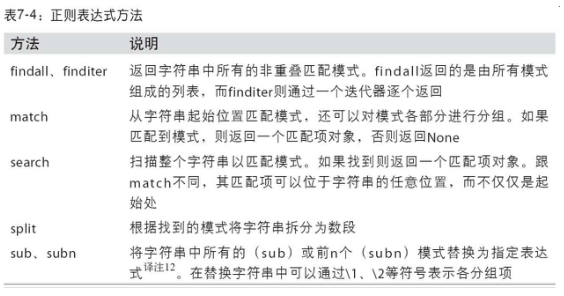

## 3.3 pandas的矢量化字符串函数



__清洗 待分析__的__散乱数据__时，常常需要做一些__字符串规整化__工作。__更为复杂__的情况是，含有__字符串__的**列**有时还含有__缺失数据__：

In [280]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com', 'Rob': 'rob@gmail.com', 'Wes': np.nan}

In [281]:
data = pd.Series(data)

data

Dave     dave@google.com
Steve    steve@gmail.com
Rob        rob@gmail.com
Wes                  NaN
dtype: object

In [282]:
data.isnull()

Dave     False
Steve    False
Rob      False
Wes       True
dtype: bool

通过__data.map__，__所有字符串和正则表达式方法__都能被应用于(传入__lambda表达式或其他函数__)__各个值__，但是如果__存在NA(null)__就会__报错__。

为了__解决这个问题__，__Series__有一些能够__跳过NA值__的__面向数组方法__，进行__字符串操作__。通过__Series__的__str属性__即可__访问这些方法__。

- 例如，我们可以通过__str.contains__检查各个电子邮件地址__是否含有"gmail"__：

In [283]:
data.str.contains('gmail')

Dave     False
Steve     True
Rob       True
Wes        NaN
dtype: object

- 也可以使用__正则表达式__，还可以加上__任意re选项__(如__IGNORECASE__)：

In [284]:
pattern

'[A-Z0-9._%+-]+@[A-Z0-9.-]+\\.[A-Z]{2,4}'

In [285]:
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [dave@google.com]
Steve    [steve@gmail.com]
Rob        [rob@gmail.com]
Wes                    NaN
dtype: object

有__两个办法__可以实现__矢量化的 元素获取 操作__：
- 要么使用__str.get__
- 要么在__str属性上__使用__索引__

In [286]:
matches = data.str.match(pattern, flags=re.IGNORECASE)

In [287]:
matches

Dave     True
Steve    True
Rob      True
Wes       NaN
dtype: object

要访问__嵌入列表__中的__元素__，我们可以传递__索引__到这__两个函数__(指的是str.get及在str属性上使用索引)中：

In [288]:
# 函数1

matches.str.get(1)

Dave    NaN
Steve   NaN
Rob     NaN
Wes     NaN
dtype: float64

In [289]:
matches.str[0]

Dave    NaN
Steve   NaN
Rob     NaN
Wes     NaN
dtype: float64

你可以利用__这种方法__(指的是传递索引到两个函数)对__字符串__进行__截取__：

In [290]:
data.str[:5]

Dave     dave@
Steve    steve
Rob      rob@g
Wes        NaN
dtype: object

In [292]:
data.str.get(0)

Dave       d
Steve      s
Rob        r
Wes      NaN
dtype: object

表7-5介绍了更多的__pandas 字符串方法__。
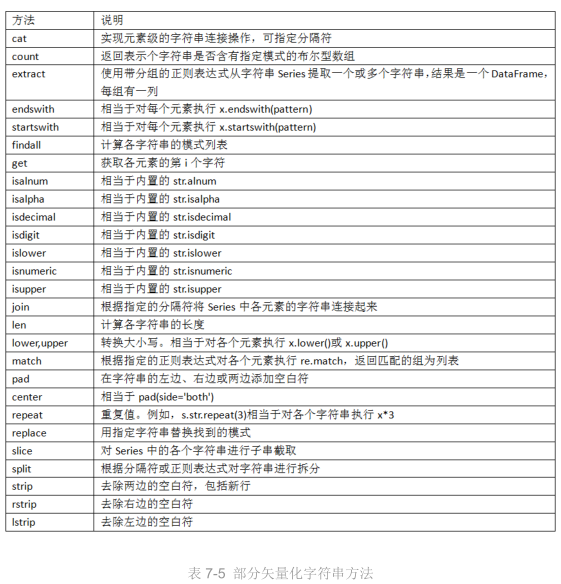

# 4.总结

__高效的 数据准备__可以让你将__更多的时间__用于__数据分析__，花__较少的时间__用于__准备工作__，这样就可以极大地__提高生产力__。

我们在__本章__中学习了__许多工具__，但覆盖并__不全面__。

__下一章__，我们会学习__pandas__的__聚合与分组__。